# 0. Part 0 - Informations

## 0.1 Overview

This notebook serves as a **sandbox workspace** for developing, testing, and refining functions related to our data analysis and simulation pipeline.

Here, we:
- **Test experimental functions** before integrating them into the main codebase,
- **Build and validate new methods** on small subsets of data,
- **Debug and profile behaviors** observed during execution,
- **Clean and modularize code** for future reuse.

> Results or visualizations here may not be final. This space is primarily intended for **exploratory work and rapid iteration**.


## 0.2 Formalism

In [2]:
# --- Order and names of variables --- #

# alpha_choice (str): Choice of the alpha configuration ('nt_random', 'periodic', 'constant_mean').
# s (int): Value of s, nucleosome size.
# l (int): Value of l, linker length.
# bpmin (int): Minimum base pair threshold.
# mu (float): Mean value for the distribution used in the simulation.
# theta (float): Standard deviation for the distribution used in the simulation.
# nt (int): Number of trajectories for the simulation.
# tmax (float): Maximum time for the simulation.
# dt (float): Time step increment.
# times (list) : List of times
# alphao (float): Probability of beeing accepted on linker sites.
# alphaf (float): Probability of beeing accepted on nucleosome sites.
# beta (float): Unfolding probability.
# Lmin (int): First point of chromatin.
# Lmax (int): Last point of chromatin.
# origin (int): Starting position for the simulation.
# bps (int): Number of base pairs per site.


# --- Title --- #

# title = (
#         f'alpha_choice_{alpha_choice}__s_{s}__l_{l}__bpmin_{bpmin}__'
#         f'mu_{mu}__theta_{theta}__nt_{nt}__tmax_{tmax}__dt_{dt}__'
#         f'alphao_{alphao}__alphaf_{alphaf}__beta_{beta}__'
#         f'Lmin_{Lmin}__Lmax_{Lmax}__origin_{origin}__bps_{bps}') 


# --- Saving --- #

# data_result = {
#     'alpha_choice': alpha_choice, 's': s, 'l': l, 'bpmin': bpmin, 'mu': mu, 'theta': theta, 
#     'nt': nt, 'tmax': tmax, 'dt': dt, 'times': times,
#     'alphao': alphao, 'alphaf': alphaf, 'beta': beta, 
#     'Lmin': Lmin, 'Lmax': Lmax, 'origin': origin, 'bps': bps,

#     'alpha_mean': alpha_mean,
#     'obs_points':obs_points, 'obs_distrib':obs_distrib,
#     'link_points':link_points, 'link_distrib':link_distrib,
#     'p':p,

#     'results':results, 'results_mean':results_mean, 'results_med':results_med, 'results_std':results_std, 
#     'v_mean':v_mean, 'v_med':v_med,

#     'tbj_points':tbj_points, 'tbj_distrib':tbj_distrib,
#     'time_bin':time_bin, 'fpt_distrib_2D':fpt_distrib_2D, 'fpt_number':fpt_number,
    
#     'dx_points':dx_points, 'dx_distrib':dx_distrib, 'dx_mean':dx_mean, 'dx_med':dx_med, 'dx_mp':dx_mp, 
#     'dt_points':dt_points, 'dt_distrib':dt_distrib, 'dt_mean':dt_mean, 'dt_med':dt_med, 'dt_mp':dt_mp, 
#     'vi_points':vi_points, 'vi_distrib':vi_distrib, 'vi_mean':vi_mean, 'vi_med':vi_med, 'vi_mp':vi_mp,

#     'alpha_0':alpha_0, 'epsilon_t':epsilon_t
# }

## 0.3 Librairies


In [1]:
from nucleo import *
print("All nucleo librairies and functions imported")

All nucleo librairies and functions imported


# I. Part A - Working On Functions

## I.1 Gillespie Functions

In [41]:
# --- One step --- #
def gillespie_algorithm_one_step(
    nt: int, tmax: float, dt: float,
    alpha_matrix: np.ndarray, beta: float, 
    Lmax: int, lenght: int, origin: int, 
    p: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    The algorithm on which the values are generated. One step !

    Args:
        nt (int): Number of trajectories for the simulation.
        tmax (float): Maximum time for the simulation.
        dt (float): Time step increment.
        alpha_matrix (np.ndarray): Matrix of acceptance probability.
        beta (float): Unfolding probability.
        Lmax (int): Last point of chromatin.
        lenght (int): Total length of chromatin.
        origin (int): Starting position for the simulation.
        p (np.ndarray): Input probability.
        epsilon_t (float): Correction time in order to not generate infinite numbers.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: matrix of results, all time, all positions
    """

    # --- Starting values --- #
    beta_matrix = np.tile(np.full(lenght, beta), (nt, 1))

    results = np.empty((nt, int(tmax/dt)))
    results.fill(np.nan)

    t_matrix = np.empty(nt, dtype=object)
    x_matrix = np.empty(nt, dtype=object)

    # --- Loop on trajectories --- #
    for _ in range(0,nt) :

        # Initialization of starting values
        t = 0
        # x = 0
        x = folding(alpha_matrix[_], origin)    # Initial calculation
        prev_x = np.copy(x)                     # Copy for later use (filling the matrix)
        ox = np.copy(x)                         # Initial point on the chromatin (used to reset trajectories to start at zero)
        i0 = 0                                  # Initial index
        i = 0                                   # Current index

        # Initial calibration
        results[_][0] = t                       # Store the initial time
        t_list = [t]                            # List to track time points
        x_list = [x-ox]                         # List to track recalibrated positions

        # --- Loop on times --- #
        while (t<tmax) :

            # Gillespie values : scanning the all genome
            r_tot = beta_matrix[_][x] + np.nansum(p[1:(Lmax-x)] * alpha_matrix[_][(x+1):Lmax])

            # # Jumping or unbinding : condition on inf times (other version)
            # if np.isinf(t_jump):                # Possibility of generating an infinite time because of no accessible positions
            #     results[_][i0:] = x-ox          # Filling with the last value
            #     break                           # Breaking the loop

            # Next time and rate of reaction
            t = t - np.log(random())/r_tot # + epsilon_t
            r0 = random()

            # Condition on time (and not on rtot) in order to capture the last jump and have weight on blocked events
            if np.isinf(t) == True:
                t = 1e307

            # Unhooking or not
            if r0<(beta_matrix[_][x]/r_tot) :
                i = int(np.floor(t/dt))                                     # Last time
                results[_][i0:int(min(np.floor(tmax/dt),i)+1)] = prev_x     # Last value
                break

            # Not beeing in a disturbed area
            if x >= (Lmax - origin) :
                i = int(np.floor(t/dt))                                     # Last time
                results[_][i0:int(min(np.floor(tmax/dt),i)+1)] = np.nan     # No value
                # print('Loop extrusion arrival at the end of the chain.')
                break

            # Choosing the reaction
            else :
                di = 1                                                      # ! di begins to 1 : p(0)=0 !
                rp = beta_matrix[_][x] + p[di] * alpha_matrix[_][x+di]      # Gillespie reaction rate

                while ((rp/r_tot)<r0) and (di<Lmax-1-x) :                   # Sum on all possible states
                    di += 1                                                 # Determining the rank of jump
                    rp += p[di] * alpha_matrix[_][x+di]                     # Sum : element per element

            # Updated parameters
            x += di

            # Acquisition of data
            t_list.append(t)
            x_list.append(x-ox)

            # Filling 
            i = int(np.floor(t/dt))
            results[_][i0:int(min(np.floor(tmax/dt),i)+1)] = int(prev_x-ox)
            i0 = i+1
            prev_x = np.copy(x)

        # All datas
        t_matrix[_] = t_list
        x_matrix[_] = x_list

    return results, t_matrix, x_matrix


# --- Two steps --- #
def gillespie_algorithm_two_steps(
    nt: int, tmax: float, dt: float,
    alpha_matrix: np.ndarray, beta: float, 
    L: np.ndarray, Lmax: int, origin: int, bps: int, 
    p: np.ndarray
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulates stochastic transitions using a two-step Gillespie algorithm.

    Args:
        nt (int): Number of trajectories to simulate.
        tmax (float): Maximum simulation time.
        dt (float): Time step increment.
        alpha_matrix (np.ndarray): Matrix representing the acceptance probabilities.
        beta (float): Probability of unfolding.
        L (np.ndarray): Chromatin structure array.
        Lmax (int): Maximum allowed chromatin length.
        origin (int): Initial position in the simulation.
        bps (int): Number of base pairs per chromatin site.
        p (np.ndarray): Input probability array.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: 
            - A matrix containing the simulation results.
            - An array of all recorded time steps.
            - An array of all recorded positions.
    """


    # --- Starting values --- #
    # beta_matrix = np.tile(np.full(len(L)*bps, beta), (nt, 1))

    results = np.empty((nt, int(tmax/dt)))
    results.fill(np.nan)

    t_matrix = np.empty(nt, dtype=object)
    x_matrix = np.empty(nt, dtype=object)

    # --- Loop on trajectories --- #
    for _ in range(0,nt) :

        # Initialization of starting values
        t, t_bind, t_rest = 0, 0, 0           # First times
        # x = 0                                 # First position
        x = folding(alpha_matrix[_], origin)  # Initial calculation
        prev_x = np.copy(x)                   # Copy for later use (filling the matrix)
        ox = np.copy(x)                       # Initial point on the chromatin (used to reset trajectories to start at zero)

        # Model
        i0, i = 0, 0
        rtot_bind, rtot_rest = 2, 2           #

        # Initial calibration
        results[_][0] = t                     # Store the initial time
        t_list = [t]                          # List to track time points
        x_list = [x-ox]                       # List to track recalibrated positions

        # --- Loop on times --- #
        while (t<tmax) :

            # --- Unbinding or not --- #

            # # Not needed for the moment
            # r0_unbind = np.random.rand()
            # if r0_unbind<(beta_matrix[_][x]):
            #     i = int(np.floor(t/dt))                                         # Last time
            #     results[_][i0:int(min(np.floor(tmax/dt),i)+1)] = prev_x-ox      # Last value
            #     break

            # --- Jumping : mandatory --- #

            # Almost instantaneous jumps (approx. 20 ms)
            x_jump = np.random.choice(L, p=p)       # Gives the x position
            x += x_jump                             # Whatever happens loop extrusion spends time trying to extrude

            # --- Jumping : edge conditions  --- #
            if x >= (Lmax - origin) :
                i = int(np.floor(t/dt))                                         # Last time
                results[_][i0:int(min(np.floor(tmax/dt),i)+1)] = np.nan         # Last value
                # print('Loop extrusion arrival at the end of the chain.')
                break

            # --- Binding or Abortion --- #

            # Binding : values
            r_bind = alpha_matrix[_][x]
            t_bind = - np.log(np.random.rand())/rtot_bind       # Random time of bind or abortion
            r0_bind = np.random.rand()                          # Random event of bind or abortion

            # Condition on time for tentative
            if np.isinf(t_bind) == True:
                t = 1e307

            # Binding : whatever happens loop extrusion spends time trying to bind event if it fails  
            t += t_bind

            # Acquisition 1
            t_list.append(t)
            x_list.append(x-ox)
      
            # Binding : Loop Extrusion (LE) occurs or not
            if r0_bind < r_bind :
                LE = True
            else : 
                LE = False
                x = prev_x

            # --- Resting after an attempt --- #

            t_rest = - np.log(np.random.rand())/rtot_rest       # Random time of resting after an attempt

            # Condition on time for resting
            if np.isinf(t_rest) == True:
                t = 1e307

            t += t_rest

            # --- Datas --- #

            # Acquisition 2
            t_list.append(t)
            x_list.append(x-ox)

            # Filling
            i = int(np.floor(t/dt))                                   
            results[_][i0:int(min(np.floor(tmax/dt),i)+1)] = int(prev_x-ox)
            i0 = i+1
            prev_x = np.copy(x)

        # All datas
        t_matrix[_] = t_list
        x_matrix[_] = x_list

    return results, t_matrix, x_matrix


# --- FACT --- #
def FACT_dynamics(array_in: np.ndarray, point: int, alphao: float, alphar: float) -> np.ndarray:
    """
    Update an obstacle block in the array if a jump lands on an obstacle.

    Parameters
    ----------
    actual_array : np.ndarray
        1D array representing the system with obstacles and linkers.
        HAS TO BE IN FLOAT FORMAT !
    
    point : int
        Index where the jump occurred.
    
    alphao : float
        The value representing obstacles in the array.
    
    alphar : float
        The value used to remodel the obstacle if the jump lands on it.

    Returns
    -------
    np.ndarray
        A new array with the obstacle modified if needed, else the original array unchanged.
    """

    if point > len(array_in):
        raise ValueError("You set point > len(array_in)")
    
    # In case for the format
    array_in = np.asarray(array_in, dtype=float)

    # Because : 0.1 + 0.2 == 0.3 >>> False
    if np.isclose(array_in[point], alphao, atol=1e-8):
        obstacle_blocks = find_blocks(array_in, alpha_value=alphao)
        interval = find_interval_containing_value(intervals=obstacle_blocks, value=point)
        
        if interval is not None:
            first_point, last_point = interval
            array_out = np.copy(array_in)
            array_out[first_point:last_point] = alphar
            return array_out
   
    return array_in


# --- Dynamics --- #
def gillespie_algorithm_two_steps_with_dynamics(
    nt: int, tmax: float, dt: float,
    alpha_matrix: np.ndarray, beta: float, 
    L: np.ndarray, Lmax: int, origin: int, bps: int, 
    p: np.ndarray,
    alphar: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulates stochastic transitions using a two-step Gillespie algorithm.

    Args:
        nt (int): Number of trajectories to simulate.
        tmax (float): Maximum simulation time.
        dt (float): Time step increment.
        alpha_matrix (np.ndarray): Matrix representing the acceptance probabilities.
        beta (float): Probability of unfolding.
        L (np.ndarray): Chromatin structure array.
        Lmax (int): Maximum allowed chromatin length.
        origin (int): Initial position in the simulation.
        bps (int): Number of base pairs per chromatin site.
        p (np.ndarray): Input probability array.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: 
            - A matrix containing the simulation results.
            - An array of all recorded time steps.
            - An array of all recorded positions.
    """


    # --- Starting values --- #
    # beta_matrix = np.tile(np.full(len(L)*bps, beta), (nt, 1))

    results = np.empty((nt, int(tmax/dt)))
    results.fill(np.nan)

    t_matrix = np.empty(nt, dtype=object)
    x_matrix = np.empty(nt, dtype=object)

    # --- Loop on trajectories --- #
    for _ in range(0,nt) :

        landscape = alpha_matrix[_]

        # Initialization of starting values
        t, t_bind, t_rest = 0, 0, 0           # First times
        # x = 0                               # First position
        x = folding(landscape, origin)        # Initial calculation
        prev_x = np.copy(x)                   # Copy for later use (filling the matrix)
        ox = np.copy(x)                       # Initial point on the chromatin (used to reset trajectories to start at zero)

        # Model
        i0, i = 0, 0
        rtot_bind, rtot_rest, rtot_FACT = 2, 2, 2

        # Initial calibration
        results[_][0] = t                     # Store the initial time
        t_list = [t]                          # List to track time points
        x_list = [x-ox]                       # List to track recalibrated positions

        # --- Loop on times --- #
        while (t<tmax) :

            # --- Jumping : mandatory --- #

            # Almost instantaneous jumps (approx. 20 ms)
            x_jump = np.random.choice(L, p=p)       # Gives the x position
            x += x_jump                             # Whatever happens loop extrusion spends time trying to extrude

            # --- Jumping : edge conditions  --- #
            if x >= (Lmax - origin) :
                i = int(np.floor(t/dt))                                         # Last time
                results[_][i0:int(min(np.floor(tmax/dt),i)+1)] = np.nan         # Last value
                # print('Loop extrusion arrival at the end of the chain.')
                break


            # --- Binding : considering FACT dynamics  --- #

            # Times to compare
            t_bind = - np.log(np.random.rand())/rtot_bind
            t_FACT = - np.log(np.random.rand())/rtot_FACT


            # Condition on dynamic concerning the landscape remodeling by FACT
            if t_FACT < t_bind:
                # print("in:", landscape, "for x=", x)
                new_landscape = np.copy(FACT_dynamics(array_in=np.copy(landscape), point=x, alphao=alphao, alphar=alphar))
                landscape = new_landscape
                # print("out", landscape, "\n for x=", x)                


            # Binding : values
            r_bind = landscape[x]
            r0_bind = np.random.rand()                          # Random event of bind or abortion

            # Condition on time for tentative
            if np.isinf(t_bind) == True:
                t = 1e307

            # Binding : whatever happens loop extrusion spends time trying to bind event if it fails  
            t += t_bind

            # Acquisition 1
            t_list.append(t)
            x_list.append(x-ox)

      
            # Binding : Loop Extrusion (LE) occurs or not
            if r0_bind < r_bind :
                LE = True
            else : 
                LE = False
                x = prev_x


            # --- Resting after an attempt --- #

            t_rest = - np.log(np.random.rand())/rtot_rest       # Random time of resting after an attempt

            # Condition on time for resting
            if np.isinf(t_rest) == True:
                t = 1e307

            t += t_rest


            # --- Datas --- #

            # Acquisition 2
            t_list.append(t)
            x_list.append(x-ox)

            # Filling
            i = int(np.floor(t/dt))                                   
            results[_][i0:int(min(np.floor(tmax/dt),i)+1)] = int(prev_x-ox)
            i0 = i+1
            prev_x = np.copy(x)

        # All datas
        t_matrix[_] = t_list
        x_matrix[_] = x_list

    return results, t_matrix, x_matrix

## I.2 Probabilities Functions

## I.3 Landscape Functions

## I.4 Analysis Functions

# II. Part B - Launches


## II.1 Two Methods

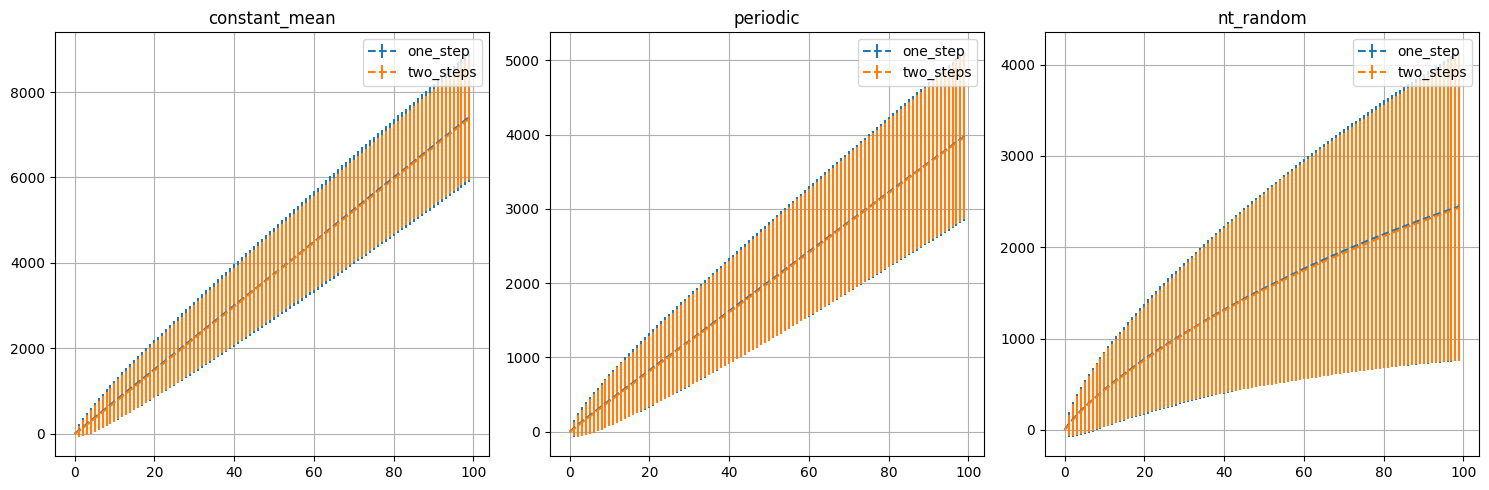

In [42]:
def run_simulation_and_plot(
    nt: int = 10_000,
    tmax: int = 100,
    dt: float = 1.0,
    Lmin: int = 0,
    Lmax: int = 50_000,
    bps: int = 1,
    origin: int = 0,
    mu: float = 300,
    theta: float = 50,
    s: int = 150,
    l: int = 50,
    bpmin: int = 10,
    alphao: float = 0,
    alphaf: float = 1,
    beta: float = 0
    ):
    """
    Runs the Gillespie simulation (one-step and two-steps versions) for three different
    alpha distribution types ('constant_mean', 'periodic', 'nt_random') and plots the mean 
    trajectories with standard deviations on subplots.

    Parameters
    ----------
    nt : int
        Number of trajectories to simulate.
    tmax : int
        Maximum simulation time.
    dt : float
        Time step.
    Lmin : int
        Minimum genome length.
    Lmax : int
        Maximum genome length.
    bps : int
        Base pair step (resolution of L array).
    origin : int
        Initial position of the particle.
    mu : float
        Mean for the gamma distribution used in p calculation.
    theta : float
        Scale for the gamma distribution used in p calculation.
    s : int
        Number of nucleosomes per group.
    l : int
        Length of nucleosome group.
    bpmin : int
        Minimum base pair allowed for binding.
    alphao : float
        Initial alpha value.
    alphaf : float
        Final alpha value.
    beta : float
        Backward rate.
    epsilon_t : float
        Threshold to avoid division by zero or nan.

    Returns
    -------
    None
    """
    L = np.arange(Lmin, Lmax, bps)
    length = len(L)
    p = proba_gamma(mu, theta, L)

    alpha_choices = ['constant_mean', 'periodic', 'nt_random']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, alpha_choice in zip(axes, alpha_choices):
        alpha_matrix, alpha_mean_value = alpha_matrix_calculation(
            alpha_choice=alpha_choice,
            s=s, l=l, bpmin=bpmin,
            alphao=alphao, alphaf=alphaf,
            Lmin=Lmin, Lmax=Lmax, bps=bps, nt=nt
        )

        # One-step Gillespie
        gillespie_os = gillespie_algorithm_one_step(
            nt=nt, tmax=tmax, dt=dt,
            alpha_matrix=alpha_matrix, beta=beta,
            Lmax=Lmax, lenght=length, origin=origin, p=p
        )
        results_os, _, _ = gillespie_os
        mean_os = np.nanmean(results_os, axis=0)
        std_os = np.std(results_os, axis=0)
        x_os = np.arange(len(mean_os))

        ax.errorbar(x=x_os, y=mean_os, yerr=std_os, label='one_step', ls='--')

        # Two-steps Gillespie
        gillespie_ts = gillespie_algorithm_two_steps(
            nt=nt, tmax=tmax, dt=dt,
            alpha_matrix=alpha_matrix, beta=beta,
            L=L, Lmax=Lmax, origin=origin, bps=bps, p=p
        )
        results_ts, _, _ = gillespie_ts
        mean_ts = np.nanmean(results_ts, axis=0)
        std_ts = np.std(results_ts, axis=0)
        x_ts = np.arange(len(mean_ts))

        ax.errorbar(x=x_ts, y=mean_ts, yerr=std_ts, label='two_steps', ls='--')

        ax.set_title(alpha_choice)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()
    

# Launch

run_simulation_and_plot()

## II.2 Inputs

In [31]:
# Inputs

alpha_choice = "periodic"

s = 150
l = 10
bpmin = 0

alphao = 0
alphaf = 1
alphar = 0.00

Lmin = 0
Lmax = 50_000
bps = 1
L = np.arange(Lmin, Lmax, bps)

nt = 10_000

mu = 250
theta = 50

tmax = 100
dt = 1

beta = 0

origin = 10_000
lenght = len(L)

## II.3 Launches

In [37]:
# Landscape
landscape = alpha_matrix_calculation(alpha_choice=alpha_choice, s=s, l=l, bpmin=bpmin,
                                    alphaf=alphaf, alphao=alphao,
                                    Lmin=Lmin, Lmax=Lmax, bps=bps,
                                    nt=nt
)[0]
landscape_mean = np.mean(landscape, axis=0)


# Probabilities
p = proba_gamma(mu=mu, theta=theta, L=L)


# Interface graphique
results_static, all_t, all_x = gillespie_algorithm_one_step(
                                                    nt=nt, tmax=tmax, dt=dt,
                                                    alpha_matrix=landscape, beta=beta,
                                                    Lmax=Lmax, lenght=lenght, origin=origin, 
                                                    p=p
)
static_mean = np.nanmean(results_static, axis=0)
static_std = np.nanstd(results_static, axis=0)

In [ ]:
# Dynamics
results_dynamic, _, _ = gillespie_algorithm_two_steps_with_dynamics(nt=nt, tmax=tmax, dt=dt,
                                                                    alpha_matrix=landscape, beta=beta,
                                                                    L=L, Lmax=Lmax, origin=origin, bps=bps, 
                                                                    p=p,
                                                                    alphar=alphar
)
dynamic_mean = np.nanmean(results_dynamic, axis=0)
print(dynamic_mean)

In [ ]:
# Comparison static and dynamic

plt.figure(figsize=(8,6))
plt.plot(static_mean, label=f'static with {alphaf} and {alphao}')
plt.plot(dynamic_mean, label=f'dynamic with {alphaf} and {alphao} and {alphar}')
plt.legend()
plt.show()

✅ Animation sauvegardée dans 'bille_anim.gif' !


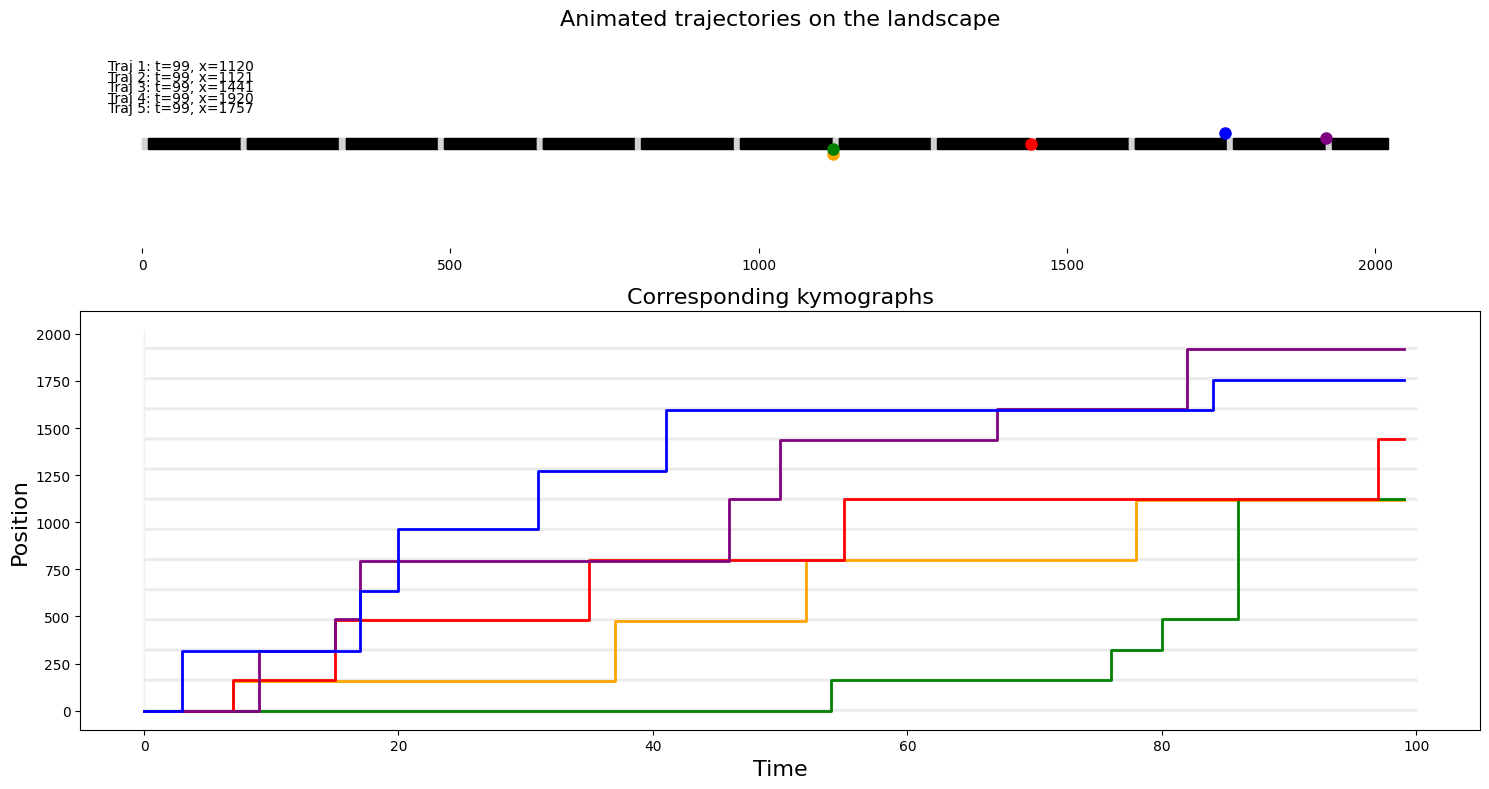

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_ball_with_trajectories(trajectories, landscape, output_path='bille_anim.gif', fps=10):
    """
    Affiche et enregistre une animation où chaque bille suit sa propre trajectoire sur le paysage.

    Args:
        trajectories (array-like): liste ou array (N, T) de trajectoires à tracer.
        landscape (array-like): paysage 1D avec 1 pour libre et 0 pour obstacle.
        output_path (str): nom du fichier GIF à sauvegarder.
        fps (int): images par seconde pour l'animation.
    """
    trajectories = np.array(trajectories)
    landscape = np.array(landscape)
    tmax = trajectories.shape[1]
    n_trajectories = trajectories.shape[0]

    xmax = max(np.max(trajectories), len(landscape)) + 50

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 2]})
    fig.patch.set_facecolor('white')

    # === 1. Animation sur ax1 ===
    ax1.set_xlim(-100, xmax + 100)
    ax1.set_ylim(-2, 2)
    ax1.set_title("Animated trajectories on the landscape", pad=10, fontsize=16)
    ax1.get_yaxis().set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
        ax1.spines[spine].set_visible(False)
    ax1.set_facecolor('white')

    # Tracé du paysage
    for i, val in enumerate(landscape):
        color = 'black' if val == 0 else 'lightgray'
        ax1.add_patch(plt.Rectangle((i, -0.1), 1, 0.2, color=color))

    # Définir les couleurs
    colors = ['orange', 'green', 'red', 'purple', 'blue']

    # Bille pour chaque trajectoire avec couleur correspondante
    balls = [ax1.plot([], [], 'o', color=colors[i % len(colors)], markersize=8)[0] for i in range(n_trajectories)]
    texts = [ax1.text(0.02, 0.85 - 0.05*i, '', transform=ax1.transAxes) for i in range(n_trajectories)]

    def init():
        for ball in balls:
            ball.set_data([], [])
        for txt in texts:
            txt.set_text('')
        return balls + texts

    def update(frame):
        for i in range(n_trajectories):
            x = trajectories[i, frame]
            balls[i].set_data([x], [0.1 * i - 0.2])
            texts[i].set_text(f'Traj {i+1}: t={frame}, x={x:.0f}')
        return balls + texts

    ani = animation.FuncAnimation(
        fig, update, frames=tmax, init_func=init,
        blit=True, interval=1000/fps
    )

    # === 2. Tracé des trajectoires dans ax2 ===
    ax2.set_title('Corresponding kymographs', size=16)
    for i in range(n_trajectories):
        ax2.step(np.arange(tmax), trajectories[i], color=colors[i % len(colors)], lw=2, label=f'Trajectory {i+1}')

    # Remplissage des zones accessibles uniquement
    landscape_y = np.arange(0, len(landscape))
    access = np.multiply(landscape, tmax)
    ax2.fill_betweenx(landscape_y, 0, access, step='post', color='lightgray', alpha=0.3, label='Accessible zones')

    ax2.set_ylabel('Position', size=16)
    ax2.set_xlabel('Time', size=16)
    # ax2.grid(True)
    # ax2.legend(fontsize=14)

    plt.tight_layout()
    ani.save(output_path, writer='pillow', fps=fps)
    print(f"✅ Animation sauvegardée dans '{output_path}' !")


# Exemple d’appel
rank = 0
n_traj = 5
trajectories = results_static[rank:rank+n_traj]
landscape = landscape[rank][0:int(np.max(trajectories) + 100)]
animate_ball_with_trajectories(trajectories, landscape)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Arc

def animate_growing_arc(time_array: np.ndarray, position_array: np.ndarray, 
                        output_filename_arc: str = 'growing_arc.gif',
                        output_filename_curve: str = 'position_over_time.gif'):
    """
    Create two animations:
    1. A moving point with a growing arc between start and current position.
    2. A curve showing position as a function of time.

    Args:
        time_array (np.ndarray): Array of time steps.
        position_array (np.ndarray): Array of positions at each time step.
        output_filename_arc (str): Filename for the arc animation GIF.
        output_filename_curve (str): Filename for the curve animation GIF.
    """

    # --- 1. Animation du point mobile + arc ---

    # Setup figure
    fig1, ax1 = plt.subplots(figsize=(10, 4))
    ax1.set_xlim(np.min(position_array) - 10, np.max(position_array) + 10)
    ax1.set_ylim(-5, np.max(position_array) * 0.3 + 10)
    ax1.set_xlabel('Position (x)')
    ax1.set_yticks([])
    ax1.set_title('Growing arc over time (horizontal)')

    # Ligne horizontale
    ax1.plot([np.min(position_array), np.max(position_array)], [0, 0], color='black', lw=1.5)

    # Points
    start_point, = ax1.plot([position_array[0]], [0], 'o', markersize=8, color='black', label='Start point')
    moving_point, = ax1.plot([], [], 'o', markersize=8, color='blue', label='Moving point')

    # Arc
    arc = Arc((0, 0), width=0, height=0, theta1=0, theta2=180, color='red', lw=2)
    ax1.add_patch(arc)

    # Texte pour le temps
    time_text = ax1.text(0.02, 0.95, '', transform=ax1.transAxes, fontsize=12, color='black')

    # Update function
    def update_arc(frame):
        x = position_array[frame]
        y = 0
        moving_point.set_data([x], [y])

        center_x = (position_array[0] + x) / 2
        center_y = 0
        radius = np.abs(x - position_array[0]) / 2

        arc.center = (center_x, center_y)
        arc.width = 2 * radius
        arc.height = radius
        arc.theta1 = 0
        arc.theta2 = 180

        time_text.set_text(f'Time: {time_array[frame]} units')

        return moving_point, arc, time_text

    ani_arc = animation.FuncAnimation(
        fig1, update_arc, frames=len(position_array), interval=50, blit=True
    )

    ax1.legend(loc='upper right')
    ani_arc.save(output_filename_arc, writer='pillow', fps=20)
    plt.close(fig1)


    # --- 2. Animation de la position en fonction du temps ---

    fig2, ax2 = plt.subplots(figsize=(8, 6))
    line, = ax2.plot([], [], lw=2, c="b")

    ax2.set_xlim(np.min(time_array), np.max(time_array))
    ax2.set_ylim(np.min(position_array) - 5, np.max(position_array) + 5)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Loop Position')
    ax2.set_title('Loop growth over time')
    ax2.grid(True)

    def update_curve(frame):
        line.set_data(time_array[:frame], position_array[:frame])
        return line,

    ani_curve = animation.FuncAnimation(
        fig2, update_curve, frames=len(time_array), interval=50, blit=True
    )

    ani_curve.save(output_filename_curve, writer='pillow', fps=20)
    plt.close(fig2)


# Exemple d'utilisation
time_array = np.arange(0, 100, 1)
palier_values = [0, 4, 7, 15, 23, 35, 50, 65, 75, 85, 90]
palier_lengths = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5])
position_array = np.repeat(palier_values, palier_lengths)
# position_array = np.arange(0, 100, 1)


animate_growing_arc(time_array, position_array,
                    output_filename_arc='animation_loop.gif',
                    output_filename_curve='animation_position.gif')

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_full_summary(landscape, p, mu, theta, results, std_results):
    """
    Génère un résumé visuel en 3 sous-figures :
    1. Le paysage avec obstacles
    2. La distribution gamma
    3. Les trajectoires (résultats) et leur moyenne

    Args:
        landscape (array): Le paysage 1D avec obstacles.
        results (ndarray): Tableau (N, T) des trajectoires déjà simulées.
        mu_array, theta_array (array): Paramètres pour la loi gamma.
        L (int): Longueur max pour la distribution.
        proba_gamma (func): Fonction générant la loi gamma.
    """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))

    # === ax1: Landscape only ===
    ax1.plot(landscape, c='b', ls='--')
    ax1.fill_between(np.arange(len(landscape)), landscape, step='post', color='b', alpha=0.3, label='accessible binding sites')
    ax1.set_title('Landscape with binding sites', size=18)
    ax1.set_ylabel('value', size=16)
    ax1.set_xlabel('position', size=16)
    ax1.set_xlim([0,1000])
    ax1.grid(True)
    ax1.legend(fontsize=14)

    # === ax2: Distributio Gamma ===
    ax2.plot(p, label='probability distribution', c='r', lw=3)
    ax2.set_title(f'Proba with mu={mu} and theta={theta}', size=18)
    ax2.set_ylim([0.00, 0.050])
    ax2.set_ylabel('p(d)', size=16)
    ax2.set_xlabel('d', size=16)
    ax2.set_xlim([0,1000])
    ax2.grid(True)
    ax2.legend(fontsize=14)

    # === ax3: Trajectories and mean ===
    tmax = results.shape[1]
    nt = results.shape[0]
    mean_trajectory = np.mean(results, axis=0)

    ax3.set_title('All trajectories & Mean', size=18)
    for n in range(nt):
        ax3.step(np.arange(tmax), results[n], c='red', lw=1, alpha=0.4)
    ax3.errorbar(x=np.arange(0,len(mean_trajectory),1), y=mean_trajectory, yerr=static_std, c='b', lw=3, label='mean trajectory')
    ax3.set_ylabel('d', size=16)
    ax3.set_xlabel('time', size=16)
    ax3.grid(True)
    ax3.legend(fontsize=14)

    plt.tight_layout()
    plt.show()


plot_full_summary(
    landscape=landscape_mean, 
    p=p,
    mu=mu, 
    theta=theta, 
    results=results_static,
    std_results=static_std
)

NameError: name 'landscape_mean' is not defined

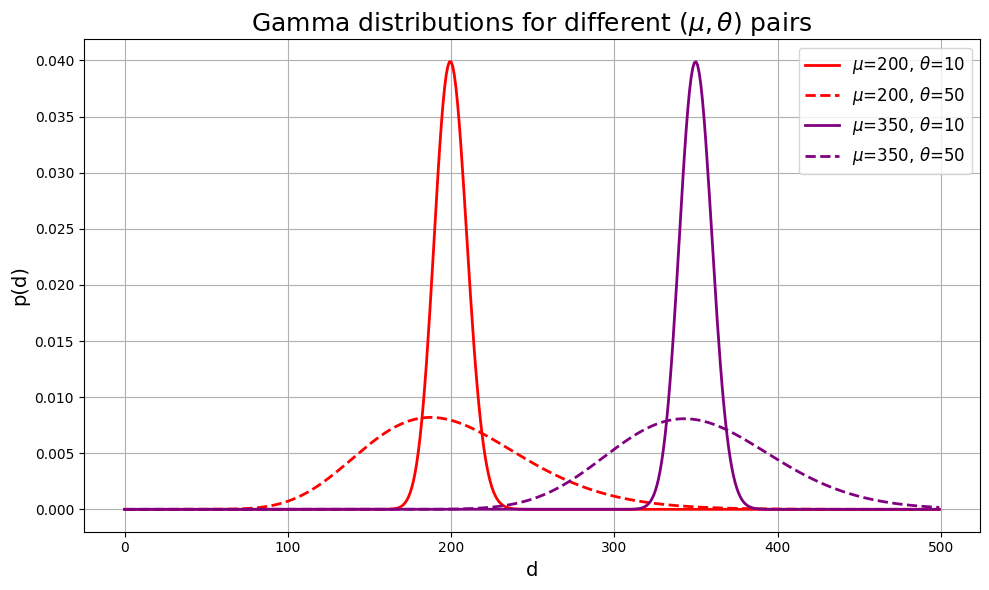

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multiple_gamma_laws(mu_array, theta_array, L, proba_gamma):
    """
    Trace 4 lois gamma différentes pour chaque combinaison (mu, theta)
    sur un seul graphe.

    Args:
        mu_array (list): deux valeurs de moyenne [mu1, mu2]
        theta_array (list): deux valeurs de dispersion [theta1, theta2]
        L (int): Longueur maximale de la distribution.
        proba_gamma (func): Fonction qui retourne la distribution gamma.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    styles = ['-', '--', '-', '--']
    colors = ['red', 'red', 'purple', 'purple']
    i = 0

    for mu in mu_array:
        for theta in theta_array:
            try:
                distrib = proba_gamma(mu, theta, L)
                if not np.any(np.isnan(distrib)) and not np.any(np.isinf(distrib)):
                    ax.plot(distrib, linestyle=styles[i % len(styles)],
                            color=colors[i % len(colors)],
                            label=f"$\\mu$={mu}, $\\theta$={theta}", lw=2)
                else:
                    print(f"⚠️ Distribution NaN/Inf pour mu={mu}, theta={theta}")
            except Exception as e:
                print(f"❌ Erreur avec mu={mu}, theta={theta} → {e}")
            i += 1

    ax.set_title("Gamma distributions for different $(\\mu, \\theta)$ pairs", fontsize=18)
    ax.set_xlabel("d", fontsize=14)
    ax.set_ylabel("p(d)", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


plot_multiple_gamma_laws(
    mu_array=[200, 350],
    theta_array=[10, 50],
    L=np.arange(0,500,1),
    proba_gamma=proba_gamma
)


# III. Part C - PSMN

In [10]:
n_config = 300_000
n_exe_one_confg = 10 # minutes
t_total_exe_minutes = n_config * n_exe_one_confg * 2 # because of Hertz
t_total_exe_heures = t_total_exe_minutes / 60
t_total_exe_jours = t_total_exe_heures / 24
print("Temps total d'éxécution sur le PMSN en jours:", t_total_exe_jours)


n_nodes = 100
n_cores = 10
t_total_PSMN = t_total_exe_jours / (n_nodes * n_cores)
print("Temps en parallèle en jours :", t_total_PSMN)

Temps total d'éxécution sur le PMSN en jours: 4166.666666666667
Temps en parallèle en jours : 4.166666666666667


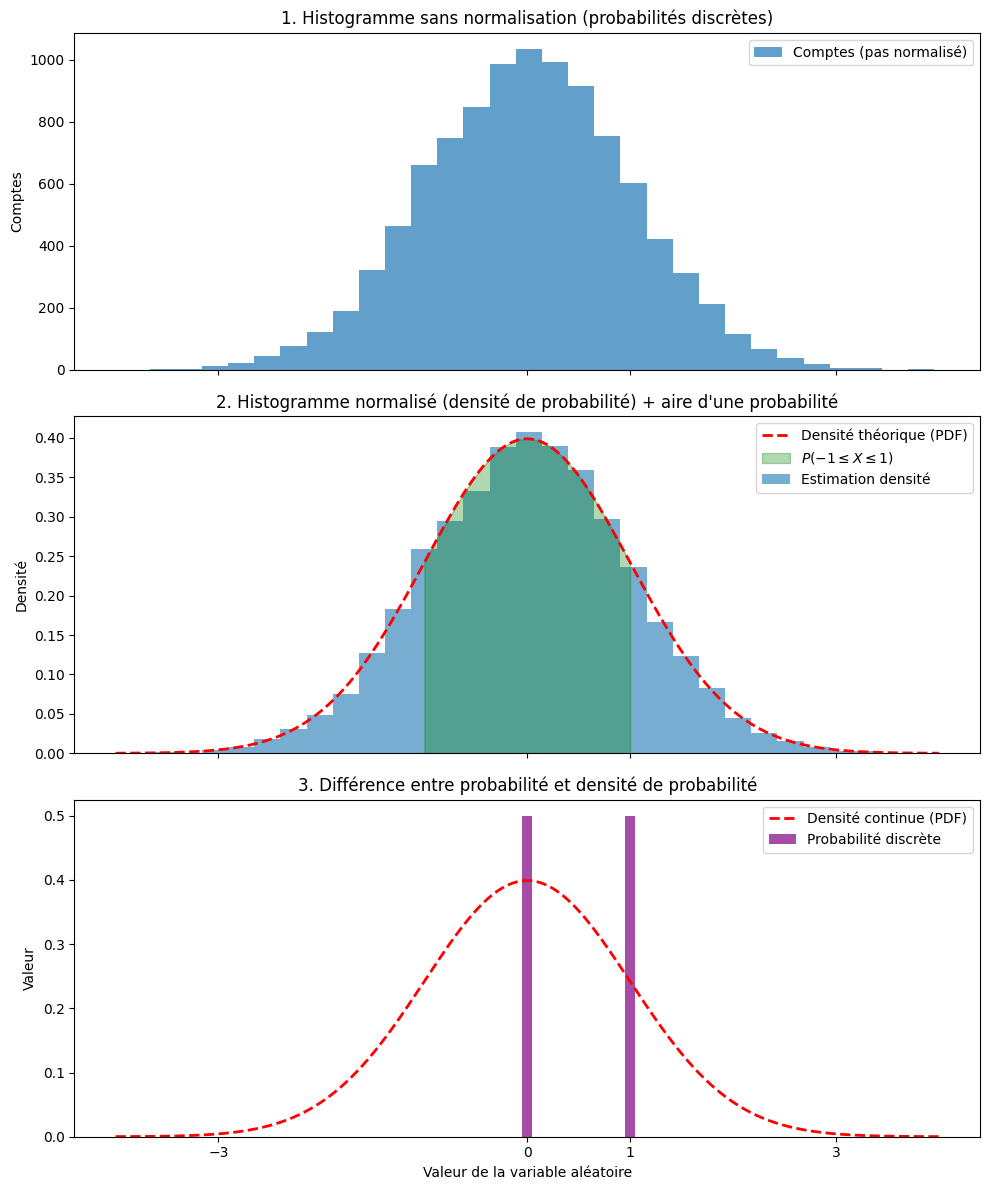

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Génération d'échantillons d'une loi normale standard
data = np.random.normal(loc=0, scale=1, size=10000)

# Histogramme sans normalisation (comptes bruts)
counts, bins1 = np.histogram(data, bins=30, density=False)

# Histogramme avec normalisation (densité de probabilité)
density, bins2 = np.histogram(data, bins=30, density=True)

bin_centers1 = 0.5 * (bins1[1:] + bins1[:-1])
bin_centers2 = 0.5 * (bins2[1:] + bins2[:-1])

# Densité réelle (fonction PDF de la loi normale)
x = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x, loc=0, scale=1)
import matplotlib.patches as patches

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# 1. Histogramme brut
axs[0].bar(bin_centers1, counts, width=(bins1[1] - bins1[0]), alpha=0.7, label="Comptes (pas normalisé)")
axs[0].set_title("1. Histogramme sans normalisation (probabilités discrètes)")
axs[0].set_ylabel("Comptes")
axs[0].legend()

# 2. Histogramme normalisé + PDF réelle
axs[1].bar(bin_centers2, density, width=(bins2[1] - bins2[0]), alpha=0.6, label="Estimation densité")
axs[1].plot(x, pdf, 'r--', linewidth=2, label="Densité théorique (PDF)")

# Ajouter une aire colorée sous une portion de la densité
a, b = -1, 1
x_fill = np.linspace(a, b, 500)
axs[1].fill_between(x_fill, norm.pdf(x_fill), alpha=0.3, color="green", label=r"$P(-1 \leq X \leq 1)$")

axs[1].set_title("2. Histogramme normalisé (densité de probabilité) + aire d'une probabilité")
axs[1].set_ylabel("Densité")
axs[1].legend()

# 3. Différence entre probabilité et densité
# Exemple : Pile ou face vs densité normale
discrete_vals = [0, 1]  # pile = 0, face = 1
discrete_probs = [0.5, 0.5]
axs[2].bar(discrete_vals, discrete_probs, width=0.1, label="Probabilité discrète", color='purple', alpha=0.7)
axs[2].plot(x, pdf, 'r--', label="Densité continue (PDF)", linewidth=2)
axs[2].set_title("3. Différence entre probabilité et densité de probabilité")
axs[2].set_xticks([-3, 0, 1, 3])
axs[2].set_ylabel("Valeur")
axs[2].legend()

plt.xlabel("Valeur de la variable aléatoire")
plt.tight_layout()
plt.show()



# .